In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from ast import literal_eval
import numpy as np
from torch.autograd import Variable
from datetime import datetime
from array import array
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import tensorflow as tf

### Define Parameters

In [46]:
# Parameters and DataLoaders
# batch_size = 100 ### adjustable
batch_size = 100 ### adjustable
num_worker = 4 ### adjustable

n_epochs = 50
num_classes = 2
learning_rate = 0.001

### Load Data

In [35]:
def converter(x):
    #define format of datetime
    return literal_eval(x)

In [109]:
class VarCallDataset(Dataset):
    """Var Call Training dataset.
       Self-defined data reader, inherited from pytorch's Dataset class. 
       Read in one row per time.
       Save space for memory.
    """

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file.
        """
        self.df = pd.read_csv(csv_file, sep='\t', index_col=[0],
                       dtype={'POS': int, 'BaseQRankSum':float,'ClippingRankSum':float,
                              'MQRankSum':float,'label': int}, 
                       converters={'alt_ratio': converter,'norm_read_depth':converter,
                                   'dir_ratio': converter,'ref_encode':converter
                                  }) # the rest window-frame has specific characters

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pos = self.df.iloc[idx, 0] # position of variant

        feature = list(self.df.iloc[idx, [1,2,4]].values) # features' values
        #feature = list(self.df.iloc[idx,1:3].values) # features' values
        # for quality-weighted ratio:
        #try:
        #    quality=literal_eval(self.df.iloc[idx,3])
            #base_qual = literal_eval(self.df.iloc[idx,5])
            
        #except: # special cases, where there is no base quality avaliable at some positions
        #    quality = self.df.iloc[idx,3]   # quality-weighted ratio
        #    quality = quality.replace("array([], dtype=float64)",'0.0').replace("[",'').replace("]",'').split(", ")
        #    quality = [float(i) for i in quality]
            #base_qual = self.df.iloc[idx,5] # base quality
            #base_qual = base_qual.replace("nan",'0.0')
            #base_qual = literal_eval(base_qual)
        
        quality = self.df.iloc[idx,3]
        quality = quality.replace("nan",'0.0')
        quality = quality.replace("array([], dtype=float64)",'0.0').replace("[",'').replace("]",'').split(", ")
        quality = [float(i) for i in quality]
        feature.append(quality)  # add to window-frame features
        
        base_qual = self.df.iloc[idx,5] # base quality
        base_qual = base_qual.replace("nan",'0.0')
        base_qual = literal_eval(base_qual)
        feature.append(base_qual) # add to window-frame features
        
        encode_ref = np.array(trail_df.iloc[0,6])[:,0:32].tolist() # encoded reference
        feature = feature + encode_ref
        
        label = self.df.iloc[idx, -1] # label
        label = np.array([label]) 
        
        if (len(feature[0]) != 32) or (len(feature[1]) != 32) or (len(feature[2]) != 32): # irregular-shaped inputs
            feature = torch.zeros([9, 32], dtype=torch.float32)
            #feature = torch.zeros([4, 32], dtype=torch.float32)
            hf = list(np.concatenate((self.df.iloc[idx,7:10].values, np.array(feature)[:,15]))) 
            #hf = list(np.concatenate((self.df.iloc[idx,4:7].values, np.array(feature)[:,15]))) 
            sample = {'feature': feature, 'label':torch.Tensor(label),
                      'hf':torch.Tensor(hf), 'pos': pos} # tranform to tensors 
            
        else: # regular-shaped inputs
            hf = list(np.concatenate((self.df.iloc[idx,7:10].values, np.array(feature)[:,15]))) # 15 is # of mid pos in window  
            #hf = list(np.concatenate((self.df.iloc[idx,4:7].values, np.array(feature)[:,15])))
            sample = {'feature':torch.Tensor(feature), 'label':torch.Tensor(label),
                      'hf':torch.Tensor(hf), 'pos': pos}
        return sample

In [110]:
# Loading data files
train_dataset = VarCallDataset("new_data_dec/200204_encode_ref_train.csv")
val_dataset = VarCallDataset("new_data_dec/200204_encode_ref_val.csv")
test_dataset= VarCallDataset("new_data_dec/200204_encode_ref_test.csv")

In [111]:
#train_loader = DataLoader(train_dataset, batch_size=batch_size,
#                        shuffle=True, num_workers=0)
#val_loader = DataLoader(val_dataset, batch_size=batch_size,
#                        shuffle=True, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=batch_size,
#                        shuffle=True, num_workers=0)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

### Build the Model

In [63]:
# Xavier initialization for Conv and Linear layer
def weights_init(m):
    classname = m.__class__.__name__
    if (classname.find('Linear') != -1) or (classname.find('Conv') != -1): 
        nn.init.xavier_normal_(m.weight.data)

#### MLP for DEBUG, no hf

In [11]:
class mlpNet(nn.Module):
    def __init__(self):
        super(mlpNet, self).__init__()
        
        # an affine operation: y = Wx + b
        self.linear = nn.Sequential(
            nn.Linear(in_features=30, out_features=256),  # 2048 = conv.size(0) = #nodes in flattern layer
            #nn.ReLU(inplace=True),
            nn.Linear(in_features=256,out_features=128),  # 120, 84 - any node# I want
            #nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes) # 2 classes as output for binary problem
        )
        
    def forward(self, x):
        flatten = x.view(x.size(0),-1) 
        output = self.linear(flatten)
        # can add dropout?
        
        return output

#### MLP for DEBUG, with hf

In [12]:
class mlp_hf_Net(nn.Module):
    def __init__(self):
        super(mlp_hf_Net, self).__init__()
        
        # an affine operation: y = Wx + b
        self.linear = nn.Sequential(
            nn.Linear(in_features=25, out_features=256),  # 2048 = conv.size(0) = #nodes in flattern layer
            #nn.ReLU(inplace=True),
            nn.Linear(in_features=256,out_features=128),  # 120, 84 - any node# I want
            #nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes) # 2 classes as output for binary problem
        )
        
    def forward(self, x, hf):
        flatten = torch.cat((x.view(x.size(0),-1),hf),dim=1) 
        output = self.linear(flatten)
        # can add dropout?
        
        return output

#### W/O Hand-crafted features

In [13]:
class VarCallNet(nn.Module):

    def __init__(self):
        super(VarCallNet, self).__init__()
        self.vc_conv = nn.Sequential(
            # 2 in channel (alt_ratio & norm_read_depth), ? output channels, kernel = 3
            nn.Conv1d(in_channels=9, out_channels=128, padding=1,kernel_size=3),
            nn.SELU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, padding=1, kernel_size=3),
            nn.SELU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # an affine operation: y = Wx + b
        self.linear = nn.Sequential(
            nn.Linear(in_features=2048, out_features=256),  # 2048 = conv.size(0) = #nodes in flattern layer
            nn.SELU(inplace=True),
            nn.Linear(in_features=256,out_features=128),  # 120, 84 - any node# I want
            nn.SELU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes) # 2 classes as output for binary problem
        )
        
    def forward(self, x):
        conv = self.vc_conv(x)
        flatten = conv.view(conv.size(0),-1)#(out_channel * temp_dim)
        output = self.linear(flatten)
        # can add dropout?
        
        return output

#### Directly Add Hand-crafted Features at the Linear Layer

In [115]:
# Directly add hf into the linear part
class dir_add_hf_Net(nn.Module):

    def __init__(self):
        super(dir_add_hf_Net, self).__init__()
        self.vc_conv = nn.Sequential(
            # 2 in channel (alt_ratio & norm_read_depth), ? output channels, kernel = 3
            nn.Conv1d(in_channels=9, out_channels=128, padding=1,kernel_size=3),
            nn.SELU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, padding=1, kernel_size=3),
            nn.SELU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # for hand-crafted layers, first expand them into hidden notes
        #self.hf_expand = nn.Sequential( )
        
        # an affine operation: y = Wx + b
        self.linear = nn.Sequential(
            nn.Linear(in_features=2060, out_features=256),  #515 = flatten layer nodes + # hf
            nn.SELU(inplace=True),
            nn.Linear(in_features=256,out_features=128),  # 120, 84 - any node# I want
            nn.SELU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes) # 2 classes as output for binary problem
        )

        
    def forward(self, x, hf):
        conv = self.vc_conv(x)
        flatten = torch.cat((conv.view(conv.size(0),-1),hf),dim=1)#(out_channel * temp_dim)  ##### +hf
        output = self.linear(flatten)
        # can add dropout?
        
        return output

#### Linear Expansion of features

In [15]:
# Directly add hf into the linear part
class hf_lp_Net(nn.Module):

    def __init__(self):
        super(hf_lp_Net, self).__init__()
        self.vc_conv = nn.Sequential(
            # 2 in channel (alt_ratio & norm_read_depth), ? output channels, kernel = 3
            nn.Conv1d(in_channels=4, out_channels=128, padding=1,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, padding=1, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # for hand-crafted layers, first expand them into hidden notes
        self.hf_expand = nn.Sequential(
            nn.Linear(in_features=3, out_features=256), 
            nn.ReLU(inplace=True)
        )
        
        # an affine operation: y = Wx + b
        self.linear = nn.Sequential(
            nn.Linear(in_features=768, out_features=256),  #515 = flatten layer nodes + # hf
            nn.Linear(in_features=256,out_features=128),  # 120, 84 - any node# I want
            nn.Linear(in_features=128, out_features=num_classes) # 2 classes as output for binary problem
        )

    def forward(self, x, hf):
        conv = self.vc_conv(x)
        hf_lp = self.hf_expand(hf)
        flatten = torch.cat((conv.view(conv.size(0),-1),hf_lp),dim=1)#(out_channel * lp_dim) 
        output = self.linear(flatten)
        # can add dropout?
        
        return output

#### Logistic Regression as Control

In [16]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(168, num_classes) # 32 x 4 + 7 (3 hf + 4 mid feature)

    def forward(self, x, hf):
        flatten = torch.cat((x.view(x.size(0),-1),hf),dim=1)#(out_channel * temp_dim) +hf
        outputs = self.linear(flatten)
        #outputs = self.linear(x)
        return outputs

#### Train &  Test

In [65]:
def train(net,mode,criterion,optimizer,scheduler,n_epochs,train_loader,val_loader):
    start = datetime.now()
    train_list =[]
    val_list = [] 
    
    for epoch in range(n_epochs): 

        # iterate over data
        for i, data in enumerate(train_loader):  
            # Convert torch tensor to Variable
            pos = data['pos'].to(device)
            features = data['feature'].to(device)
            labels = data['label'].squeeze(1).to(device=device, dtype=torch.int64) # crossentropy receive N of labels, change from [0, C-1]            hf = data['hf'].to(device)
            hf =  data['hf'].to(device)
            # Forward + Backward + Optimize
            
            optimizer.zero_grad()  # zero the gradient buffer
            if mode == 'no_hf':
                outputs = net(features)
            else:
                outputs = net(features,hf)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            if (i+1) % 64 == 0:
                ### calculate validation acc
                with torch.no_grad():
                    val_correct = 0
                    val_total = 0
                    for val_data in val_loader:
                        val_inputs, val_labels = val_data['feature'].to(device), val_data['label'].squeeze(1).to(device=device, dtype=torch.int64) 
                        val_hf = val_data['hf'].to(device)
                        
                        if mode == 'no_hf':
                            val_outputs = net(val_inputs)
                        else:
                            val_outputs = net(val_inputs, val_hf)
                        
                        _, val_predicted = torch.max(val_outputs.data, 1)
                        val_total += val_labels.size(0)
                        val_correct += (val_predicted == val_labels).sum().item()
                ###
                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                
                print ('Epoch [%d/%d], Step [%d/%d], Train Xent Loss: %.4f' 
                        %(epoch+1, n_epochs, i+1, len(train_dataset)//batch_size, loss.data))
                
                ## For DEBUG:
                if torch.isnan(loss.data):
                    print("POSPOSPOS: ",pos)
                print("learning rate: ", lr_step)
                # print train scores and val scores
                _, predicted = torch.max(outputs.data, 1)
                total = labels.size(0)
                correct = (predicted == labels).sum().item()

            
                print('Train Acc: %.4f %%, Val Acc: %.4f %%' 
                      % (100 * correct / total, 100 * val_correct / val_total))
                train_list.append(100 * correct / total)
                val_list.append(100 * val_correct / val_total)
        # update LR after each epoch
        scheduler.step()
    
    ### Find the samples in val set that are wrong
    
    with torch.no_grad():
        false_pos_list = []
        for val_data in val_loader:
            val_inputs, val_labels = val_data['feature'].to(device), val_data['label'].squeeze(1).to(device=device, dtype=torch.int64) 
            val_hf = val_data['hf'].to(device)
            val_pos = val_data['pos']
                        
            if mode == 'no_hf':
                val_outputs = net(val_inputs)
            else:
                val_outputs = net(val_inputs, val_hf)
                        
            _, val_predicted = torch.max(val_outputs.data, 1)
            false_pos_list.append(val_pos[val_predicted != val_labels])
            
    ############
    
    end = datetime.now()
    total_time = end-start
    print('Time elapsed (hh:mm:ss.ms) {}'.format(total_time))
    return false_pos_list,train_list,val_list

In [66]:
def test_acc(net,mode,criterion,optimizer,n_epochs,test_loader):# Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data['feature'].to(device), data['label'].squeeze(1).to(device=device, dtype=torch.int64) 
            hf = data['hf'].to(device)
            if mode == 'no_hf':
                vc_outputs = net(inputs)
            else:
                vc_outputs = net(inputs, hf)
                
            _, predicted = torch.max(vc_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test data: %.4f %%' % (
        100 * correct / total))

In [67]:
def test_each_acc(net,mode,criterion,optimizer,n_epochs,test_loader):# Get test accuracy for each class.
    classes = ['Wrong VC','True VC']
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data['feature'].to(device), data['label'].squeeze(1).to(device=device, dtype=torch.int64)
            hf = data['hf'].to(device)
            if mode == 'no_hf':
                vc_outputs = net(inputs)
            else:
                vc_outputs = net(inputs, hf)
                
            _, predicted = torch.max(vc_outputs, 1)
            c = (predicted == labels).squeeze()
        
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(2):
        print('Accuracy of %5s : %.4f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    tp = class_correct[1]
    fp = class_total[1] - tp
    tn = class_correct[0]
    fn = class_total[0] - tn
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    print('Precision: %.4f Recall: %.4f  F1 score: %.4f' 
          %(precision, recall, f1_score))

### Training the Model & Test Results

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#net.to(device)

cpu


#### With hand-crafted features

In [116]:
### 2. With hand-crafted Features
net = dir_add_hf_Net().to(device)
criterion = nn.CrossEntropyLoss() # only two classes, binary question
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # SGD is great, but could also try other optimiers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3) # learning rate 

In [117]:
net.apply(weights_init) 

dir_add_hf_Net(
  (vc_conv): Sequential(
    (0): Conv1d(9, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): SELU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): SELU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2060, out_features=256, bias=True)
    (1): SELU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): SELU(inplace=True)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [118]:
mis_list,train_list,val_list = train(net,'hf',criterion,optimizer,scheduler,n_epochs,train_loader,val_loader)

Epoch [1/50], Step [64/65], Train Xent Loss: 0.2181
learning rate:  0.001
Train Acc: 92.0000 %, Val Acc: 92.7096 %
Epoch [2/50], Step [64/65], Train Xent Loss: 0.1814
learning rate:  0.001
Train Acc: 96.0000 %, Val Acc: 94.6537 %
Epoch [3/50], Step [64/65], Train Xent Loss: 0.1743
learning rate:  0.001
Train Acc: 96.0000 %, Val Acc: 94.8967 %
Epoch [4/50], Step [64/65], Train Xent Loss: 0.0953
learning rate:  0.001
Train Acc: 98.0000 %, Val Acc: 95.7473 %
Epoch [5/50], Step [64/65], Train Xent Loss: 0.0504
learning rate:  0.001
Train Acc: 99.0000 %, Val Acc: 96.3548 %
Epoch [6/50], Step [64/65], Train Xent Loss: 0.1339
learning rate:  0.001
Train Acc: 96.0000 %, Val Acc: 96.9623 %
Epoch [7/50], Step [64/65], Train Xent Loss: 0.1009
learning rate:  0.001
Train Acc: 96.0000 %, Val Acc: 97.0838 %
Epoch [8/50], Step [64/65], Train Xent Loss: 0.0742
learning rate:  0.001
Train Acc: 98.0000 %, Val Acc: 97.4484 %
Epoch [9/50], Step [64/65], Train Xent Loss: 0.0889
learning rate:  0.001
Train 

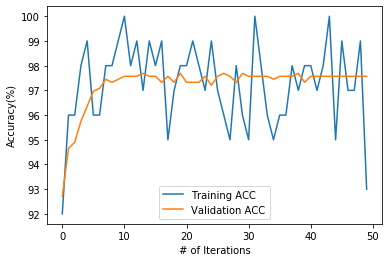

In [119]:
# Plot train - val acc curve
plt.plot(train_list,label="Training ACC")
plt.plot(val_list,label="Validation ACC")
plt.xlabel("# of Iterations")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

In [120]:
test_acc(net,'hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of the network on the test data: 96.3548 %


In [121]:
test_each_acc(net,'hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of Wrong VC : 97.4828 %
Accuracy of True VC : 95.0777 %
Precision: 0.9508 Recall: 0.9709  F1 score: 0.9607


In [62]:
# for auPRC
val_pred_list = []
val_true_list = []
mode = "hf"

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data['feature'].to(device), val_data['label'].squeeze(1).to(device=device, dtype=torch.int64) 
        val_hf = val_data['hf'].to(device)
        val_pos = val_data['pos']
                        
        if mode == 'no_hf':
                val_outputs = net(val_inputs)
        else:
            val_outputs = net(val_inputs, val_hf)
                        
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_pred_list.append(val_predicted)
        val_true_list.append(val_labels)

In [78]:
val_pred = [i.numpy() for i in val_pred_list] 
val_pred = np.concatenate(val_pred).ravel()
val_true = [i.numpy() for i in val_true_list] 
val_true = np.concatenate(val_true).ravel()

In [83]:
# calculate auPRC for validation set
auprc = average_precision_score(val_true, val_pred)
prec, rec, thres = precision_recall_curve(val_true, val_pred)

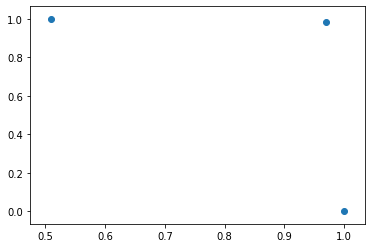

In [85]:
plt.scatter(prec,rec)

#### No hand-crafted features

In [31]:
### 1. No hand-crafted Features
net = VarCallNet().to(device)
criterion = nn.CrossEntropyLoss() # only two classes, binary question
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # SGD is great, but could also try other optimiers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3) # learning rate 

In [32]:
net.apply(weights_init) 

VarCallNet(
  (vc_conv): Sequential(
    (0): Conv1d(5, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): SELU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): SELU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): SELU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): SELU(inplace=True)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [33]:
mis_list = train(net,'no_hf',criterion,optimizer,scheduler,n_epochs,train_loader,val_loader)

Epoch [1/50], Step [64/65], Train Xent Loss: 0.2476
learning rate:  0.001
Train Acc: 89.0000 %, Val Acc: 87.8197 %
Epoch [2/50], Step [64/65], Train Xent Loss: 0.2092
learning rate:  0.001
Train Acc: 93.0000 %, Val Acc: 92.4482 %
Epoch [3/50], Step [64/65], Train Xent Loss: 0.1421
learning rate:  0.001
Train Acc: 95.0000 %, Val Acc: 93.9099 %
Epoch [4/50], Step [64/65], Train Xent Loss: 0.0979
learning rate:  0.001
Train Acc: 98.0000 %, Val Acc: 96.5895 %
Epoch [5/50], Step [64/65], Train Xent Loss: 0.1333
learning rate:  0.001
Train Acc: 94.0000 %, Val Acc: 96.9549 %
Epoch [6/50], Step [64/65], Train Xent Loss: 0.2111
learning rate:  0.001
Train Acc: 95.0000 %, Val Acc: 96.9549 %
Epoch [7/50], Step [64/65], Train Xent Loss: 0.1002
learning rate:  0.001
Train Acc: 97.0000 %, Val Acc: 96.9549 %
Epoch [8/50], Step [64/65], Train Xent Loss: 0.1100
learning rate:  0.001
Train Acc: 97.0000 %, Val Acc: 97.3203 %
Epoch [9/50], Step [64/65], Train Xent Loss: 0.0441
learning rate:  0.001
Train 

In [34]:
test_acc(net,'no_hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of the network on the test data: 96.2241 %


In [35]:
test_each_acc(net,'no_hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of Wrong VC : 95.1724 %
Accuracy of True VC : 97.4093 %
Precision: 0.9741 Recall: 0.9471  F1 score: 0.9604


## (3) Logistic Regression 

In [36]:
### Control Case
net = LogisticRegression().to(device)
criterion = nn.CrossEntropyLoss() # only two classes, binary question
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # SGD is great, but could also try other optimiers
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3) # learning rate 
net.apply(weights_init)

LogisticRegression(
  (linear): Linear(in_features=168, out_features=2, bias=True)
)

In [37]:
mis_list = train(net,'hf',criterion,optimizer,scheduler,n_epochs,train_loader,val_loader)

Epoch [1/50], Step [64/65], Train Xent Loss: 0.4472
learning rate:  0.001
Train Acc: 87.0000 %, Val Acc: 85.1401 %
Epoch [2/50], Step [64/65], Train Xent Loss: 0.3286
learning rate:  0.001
Train Acc: 88.0000 %, Val Acc: 87.4543 %
Epoch [3/50], Step [64/65], Train Xent Loss: 0.3291
learning rate:  0.001
Train Acc: 86.0000 %, Val Acc: 87.3325 %
Epoch [4/50], Step [64/65], Train Xent Loss: 0.2895
learning rate:  0.001
Train Acc: 91.0000 %, Val Acc: 88.4287 %
Epoch [5/50], Step [64/65], Train Xent Loss: 0.3245
learning rate:  0.001
Train Acc: 89.0000 %, Val Acc: 88.6724 %
Epoch [6/50], Step [64/65], Train Xent Loss: 0.2489
learning rate:  0.001
Train Acc: 93.0000 %, Val Acc: 89.2814 %
Epoch [7/50], Step [64/65], Train Xent Loss: 0.2123
learning rate:  0.001
Train Acc: 93.0000 %, Val Acc: 89.5250 %
Epoch [8/50], Step [64/65], Train Xent Loss: 0.2467
learning rate:  0.001
Train Acc: 90.0000 %, Val Acc: 90.2558 %
Epoch [9/50], Step [64/65], Train Xent Loss: 0.3306
learning rate:  0.001
Train 

In [38]:
test_acc(net,'hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of the network on the test data: 91.4738 %


In [39]:
test_each_acc(net,'hf',criterion,optimizer,n_epochs,test_loader)

Accuracy of Wrong VC : 86.4368 %
Accuracy of True VC : 97.1503 %
Precision: 0.9715 Recall: 0.8641  F1 score: 0.9146


### Observe wrong variants in IGV

In [312]:
#mis_list

In [33]:
mis = [item for sublist in mis_list for item in sublist]

In [34]:
mis

[tensor(29830908),
 tensor(59862248),
 tensor(25943376),
 tensor(52477592),
 tensor(52458077),
 tensor(44274319),
 tensor(62767035),
 tensor(31985041),
 tensor(61315242),
 tensor(62197905),
 tensor(4570550),
 tensor(46527454),
 tensor(1239615),
 tensor(46457390),
 tensor(59768013),
 tensor(36598227),
 tensor(54423713)]

In [ ]:
df['variant_POS'] == 4570550

In [225]:
mode = 'hf'
with torch.no_grad():
    false_pos_list = []
    for val_data in val_loader:
        val_inputs, val_labels = val_data['feature'].to(device), val_data['label'].squeeze(1).to(device=device, dtype=torch.int64) 
        val_hf = val_data['hf'].to(device)
        val_pos = val_data['pos']
                        
        if mode == 'no_hf':
            val_outputs = net(val_inputs)
        else:
            val_outputs = net(val_inputs, val_hf)
                        
        _, val_predicted = torch.max(val_outputs.data, 1)
        false_pos_list.append(val_pos[val_predicted != val_labels])

In [228]:
with open('data/wrong_pred_pos_all_ds_hf.txt', 'w') as filehandle:
    for listitem in false_pos_list:
        filehandle.write('%s\n' % listitem)

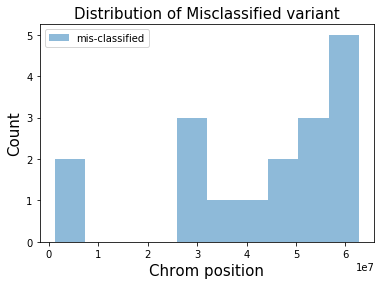

In [35]:
plt.hist(mis,alpha=0.5,label = 'mis-classified')
#plt.hist(true_pos_dist,alpha=0.5, label = 'TP')
plt.xlabel("Chrom position",fontSize=15)
plt.ylabel("Count",fontSize=15)
plt.title("Distribution of Misclassified variant",fontSize=15)
plt.legend()

#### Plot distributions of variables

In [128]:
df = pd.read_csv("new_data_dec/191218_cfr_add_dir_qual_val.csv", sep='\t', index_col=[0],
                       dtype={'POS': int, 'BaseQRankSum':float,'ClippingRankSum':float,
                              'MQRankSum':float,'label': int}, 
                       converters={'alt_ratio': converter,'norm_read_depth':converter,
                                  'dir_ratio': converter})

In [129]:
df.shape

(821, 10)

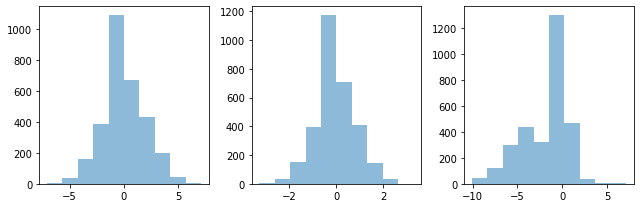

In [328]:
fig,axs = plt.subplots(1,3,figsize=(9,3))
axs[0].hist(df['BaseQRankSum'],alpha=0.5)
axs[1].hist(df['ClippingRankSum'],alpha=0.5)
axs[2].hist(df['MQRankSum'],alpha=0.5)
plt.tight_layout()